# Lyric Logic NLP Project

## Index

-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading the Data](#dataset)
    <br>
-   [Cleaning the Data](#clean)
    <br>
-   [Data Visualization](#vis)
    <br>
-   [Preprocessing the Data](#pre)
    <br>
-   [Feature Extraction](#feat)
    <br>
-   [CNN Model](#cnn)
    <br>
-   [LSTM Model](#lstm)

## Including Necessary Libraries<a id='libs'></a>


In [1]:
# Disable warnings (comment this cell to turn on warnings)
import warnings
import logging


def warn(*args, **kwargs):
    pass


warnings.warn = warn
logging.getLogger("tensorflow").disabled = True

In [2]:
import os  # For file operations and paths
import time  # For measuring time taken to run specific cells
import glob  # For getting testing images paths

import chime  # For making a sound when there is an error

import numpy as np  # For dealing with arrays and matrices
import pandas as pd  # For dealing with dataframes

import matplotlib.pyplot as plt  # For plotting images and graphs
from wordcloud import WordCloud  # For plotting word clouds

from nltk.corpus import stopwords  # For removing stopwords
from langdetect import detect  # For detecting the language of a text
from nltk.stem import WordNetLemmatizer  # For lemmatizing words
from nltk.stem import SnowballStemmer  # For stemming words
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenizing text

from sklearn.model_selection import (
    train_test_split,
)  # For splitting the data into training and testing sets
from tensorflow.keras.utils import to_categorical  # For one-hot encoding the labels
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences,
)  # For padding sequences
from tensorflow.keras.initializers import (
    Constant,
)  # For initializing the embedding layer with GloVe embeddings


# For building the model
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    LSTM,
    Embedding,
)


import tensorflow as tf  # For configuring the GPU

import dill  # For saving the session

## Other Utilites<a id='uti'></a>


In [3]:
# Setting the path to the dataset
DATASET_PATH = "./artist_lyrics"
print("Dataset path is: " + DATASET_PATH)

Dataset path is: C:\Datasets\Song Lyrics Dataset


In [4]:
# Configuring the GPU for training the model

gpus = tf.config.list_physical_devices("GPU")  # Getting the list of GPUs available

# If there is a GPU available, then set the GPU to be used for training the model
if gpus:
    print("GPUs Available: ", gpus)

    # If there are two GPUs available, then use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    # If there is only one GPU available, then use the first GPU
    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)

# If there is no GPU available, then use the CPU
else:
    print("No GPU Available")

No GPU Available


In [5]:
# Initializing chime
chime.theme("sonic")
chime.notify_exceptions()

## Loading the Data <a id='dataset'></a>


In [6]:
# Getting the paths of the CSV files
csv_files_path = DATASET_PATH + "\*.csv"
csv_files = glob.glob(csv_files_path)

In [7]:
print("CSV Files: ", csv_files)

CSV Files:  ['C:\\Datasets\\Song Lyrics Dataset\\ArianaGrande.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Beyonce.csv', 'C:\\Datasets\\Song Lyrics Dataset\\BillieEilish.csv', 'C:\\Datasets\\Song Lyrics Dataset\\BTS.csv', 'C:\\Datasets\\Song Lyrics Dataset\\CardiB.csv', 'C:\\Datasets\\Song Lyrics Dataset\\CharliePuth.csv', 'C:\\Datasets\\Song Lyrics Dataset\\ColdPlay.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Drake.csv', 'C:\\Datasets\\Song Lyrics Dataset\\DuaLipa.csv', 'C:\\Datasets\\Song Lyrics Dataset\\EdSheeran.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Eminem.csv', 'C:\\Datasets\\Song Lyrics Dataset\\JustinBieber.csv', 'C:\\Datasets\\Song Lyrics Dataset\\KatyPerry.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Khalid.csv', 'C:\\Datasets\\Song Lyrics Dataset\\LadyGaga.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Maroon5.csv', 'C:\\Datasets\\Song Lyrics Dataset\\NickiMinaj.csv', 'C:\\Datasets\\Song Lyrics Dataset\\PostMalone.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Rihanna.csv', 'C:\\Datasets\\

In [8]:
# Load the CSV files into a dataframe
df_list = []
for file in csv_files:
    df_list.append(pd.read_csv(file))

In [9]:
# Load the dataframes into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)

In [10]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist,Title,Album,Date,Lyric,Year,Unnamed: 0
43,Ariana Grande,​obvious,Positions,2020-10-30,i love the taste of you in the morning keep me...,2020.0,NaN
1654,Drake,Over My Dead Body,Take Care,2011-11-15,chantal kreviazuk how i'm feeling it doesn't m...,2011.0,23.0
4635,Nicki Minaj,Wave Ya Hand,Pink Friday,2011-02-23,wave ya hand if you look good throw some shade...,2011.0,138.0
3188,Justin Bieber,Get Me,Changes,2020-01-28,pre justin bieber oh you don't compare don't f...,2020.0,27.0
2291,Dua Lipa,Hallucinate (Paul Woolford Remix),NaN,2020-07-23,call my name call my name call my name call my...,2020.0,194.0


In [11]:
# Describe the dataframe
df.describe()

,Year,Unnamed: 0
count,4278.000000,5719.000000
mean,2011.837775,175.362476
std,53.725459,121.678762
min,1.000000,0.000000
25%,2010.000000,71.000000
50%,2014.000000,156.000000
75%,2018.000000,263.000000
max,2022.000000,520.000000


In [12]:
# Checking for null values in the training data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6027 entries, 0 to 6026
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      6027 non-null   object 
 1   Title       6027 non-null   object 
 2   Album       4453 non-null   object 
 3   Date        4278 non-null   object 
 4   Lyric       5981 non-null   object 
 5   Year        4278 non-null   float64
 6   Unnamed: 0  5719 non-null   float64
dtypes: float64(2), object(5)
memory usage: 329.7+ KB


In [13]:
# Show the number of null values in each column
df.isnull().sum()

Artist           0
Title            0
Album         1574
Date          1749
Lyric           46
Year          1749
Unnamed: 0     308
dtype: int64

In [14]:
# Show the names and the count of the unique artists in the dataset
df["Artist"].value_counts()

Artist
Eminem           521
Taylor Swift     479
Drake            466
Beyoncé          406
Rihanna          405
Lady Gaga        402
Justin Bieber    348
Coldplay         344
Katy Perry       325
Nicki Minaj      323
Ariana Grande    308
Ed Sheeran       296
BTS (방탄소년단)      278
Dua Lipa         247
Maroon 5         197
Selena Gomez     175
Post Malone      148
Billie Eilish    145
Charlie Puth      75
Cardi B           75
Khalid            64
Name: count, dtype: int64

In [15]:
# Display the lyrics of the first song in the dataset
df["Lyric"][0]

"thought i'd end up with sean but he wasn't a match wrote some songs about ricky now i listen and laugh even almost got married and for pete i'm so thankful wish i could say thank you to malcolm 'cause he was an angel  pre one taught me love one taught me patience and one taught me pain now i'm so amazing say i've loved and i've lost but that's not what i see so look what i got look what you taught me and for that i say   thank you next next thank you next next thank you next i'm so fuckin' grateful for my ex thank you next next thank you next next thank you next next i'm so fuckin'   spend more time with my friends i ain't worried 'bout nothin' plus i met someone else we havin' better discussions i know they say i move on too fast but this one gon' last 'cause her name is ari and i'm so good with that so good with that  pre she taught me love love she taught me patience patience how she handles pain pain that shit's amazing yeah she's amazing i've loved and i've lost yeah yeah but tha

## Clean the Data <a id='clean'></a>


In [16]:
# Remove unnecessary columns from the dataframe
df = df.drop(columns=["Album", "Date", "Unnamed: 0"])

In [17]:
# Rename the columns to more descriptive names
df.rename(
    columns={
        "Artist": "Artist Name",
        "Title": "Song Title",
        "Year": "Release Year",
        "Lyric": "Song Lyrics",
    },
    inplace=True,
)

In [18]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year
1051,BTS (방탄소년단),フンタン少年団 (Boyz With Fun) (Japanese Ver.),japanese さぁ wussup we フンタン少年団 wussup wussup w...,2016.0
3700,Katy Perry,Hot N Cold (Yelle Remix),katy perry hot hot hot katy perry you change...,2008.0
2576,Ed Sheeran,The A Team - Live and in Session,white lips pale face breathing in the snowflak...,NaN
958,BTS (방탄소년단),00:00 (Zero O’Clock),방탄소년단 0000 zero o'clock 가사 jungkook 그런 날 있잖...,2020.0
2800,Eminem,As the World Turns,i don't know yes man why this world keeps turn...,1999.0


In [19]:
# Remove rows where lyrics is null
df = df.dropna(subset=["Song Lyrics"])

In [20]:
# Remove any duplicate rows
df = df.drop_duplicates()

In [21]:
# Show the number of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5981 entries, 0 to 6026
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Artist Name   5981 non-null   object 
 1   Song Title    5981 non-null   object 
 2   Song Lyrics   5981 non-null   object 
 3   Release Year  4247 non-null   float64
dtypes: float64(1), object(3)
memory usage: 233.6+ KB


In [22]:
# Remove rows containing artists with less than 200 songs
df = df.groupby("Artist Name").filter(lambda x: len(x) > 200)

In [23]:
# Remove BTS from the dataset, (since I am not a fan of their music)
df = df[df["Artist Name"] != "BTS (방탄소년단)"]

In [24]:
# Show the names and the count of the unique artists in the dataset
df["Artist Name"].value_counts()

Artist Name
Eminem           521
Taylor Swift     477
Drake            464
Beyoncé          406
Rihanna          397
Lady Gaga        395
Justin Bieber    347
Coldplay         333
Katy Perry       324
Nicki Minaj      321
Ariana Grande    308
Ed Sheeran       294
Dua Lipa         246
Name: count, dtype: int64

In [25]:
# Show the release years and their counts
df["Release Year"].value_counts()

Release Year
2020.0    319
2011.0    289
2017.0    237
2019.0    234
2010.0    219
2009.0    209
2013.0    204
2016.0    198
2018.0    196
2014.0    177
2008.0    154
2015.0    150
2012.0    148
2007.0    123
2006.0    111
2002.0     59
2005.0     51
2003.0     50
2000.0     46
1999.0     36
2001.0     24
2021.0     23
2004.0     22
1998.0     13
1996.0     13
1997.0     10
1.0         3
1988.0      2
1990.0      2
2022.0      2
1729.0      1
1993.0      1
1982.0      1
Name: count, dtype: int64

In [26]:
# Remove any rows where the release year is less than 2000
df = df[df["Release Year"] >= 2000]

In [27]:
# Predict the missing values in the release year column using interpolation
df = df.interpolate(method="linear")

In [28]:
# Change the datatype of the release year to integer
df["Release Year"] = df["Release Year"].astype(int)

In [29]:
# Reset the index of the dataframe
df = df.reset_index(drop=True)

In [30]:
# Show the number of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Artist Name   3245 non-null   object
 1   Song Title    3245 non-null   object
 2   Song Lyrics   3245 non-null   object
 3   Release Year  3245 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 88.9+ KB


In [31]:
# Describe the dataframe
df.describe()

,Release Year
count,3245.000000
mean,2012.905393
std,5.138704
min,2000.000000
25%,2009.000000
50%,2013.000000
75%,2017.000000
max,2022.000000


In [32]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year
1553,Eminem,Remind Me,eminem yo i bust in devilish grin disgustin' a...,2017
2668,Rihanna,Roc Me Out,yeah yeah so give it to me like i want it th...,2011
199,Ariana Grande,Knew Better / Forever Boy [DWT Version],part i knew better say you could turn me on ...,2017
699,Coldplay,Pour Me (Live at the Hollywood Bowl),poor me floatin' out to sea an opportunity tha...,2005
1191,Dua Lipa,Complicated,lyrics for this song have yet to be released p...,2020


## Data Visualization <a id="vis"></a>


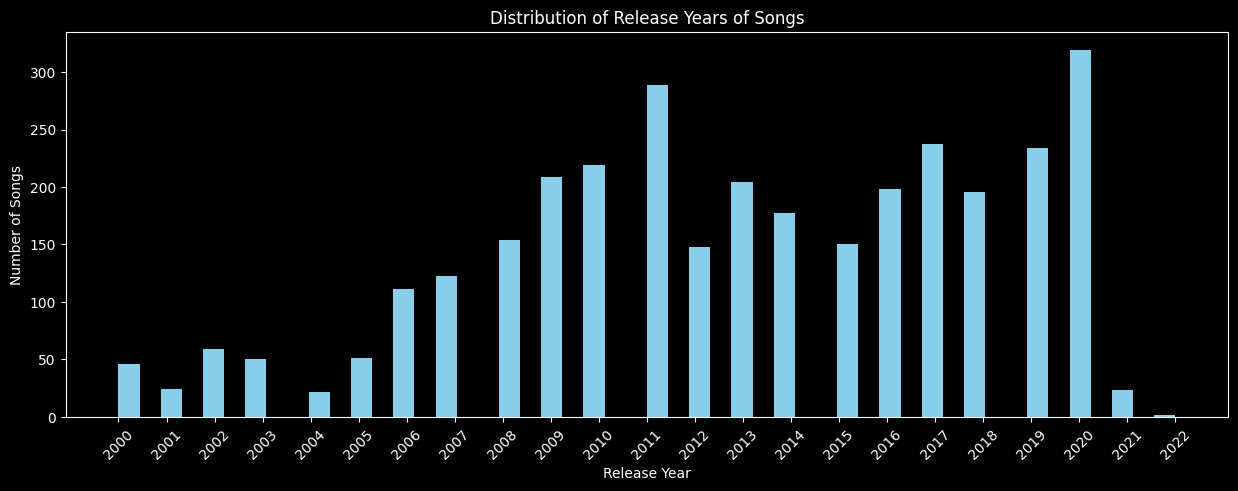

In [33]:
# Visualize the distribution of the release years of the songs
plt.figure(figsize=(15, 5))
plt.hist(df["Release Year"], bins=50, color="skyblue")
plt.xlabel("Release Year")
plt.ylabel("Number of Songs")
plt.xticks(
    np.arange(df["Release Year"].min(), df["Release Year"].max() + 1), rotation=45
)
plt.title("Distribution of Release Years of Songs")
plt.show()

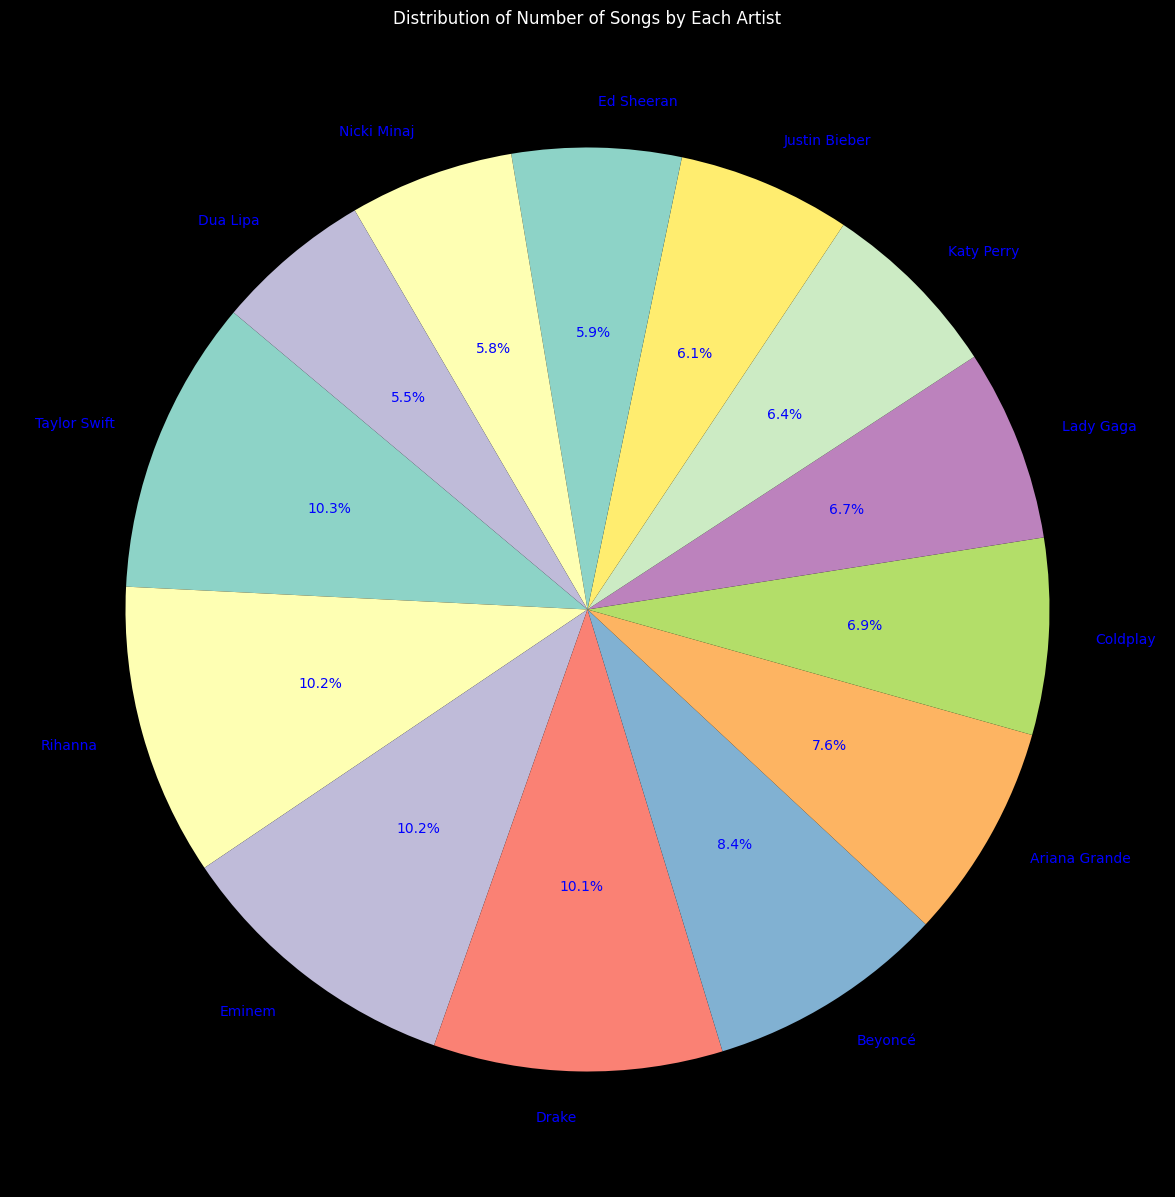

In [34]:
# Visualize the distribution of the number of songs by each artist
plt.figure(figsize=(15, 15))
df["Artist Name"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=140, textprops={"color": "b"}
)
plt.title("Distribution of Number of Songs by Each Artist")
plt.ylabel("")
plt.show()

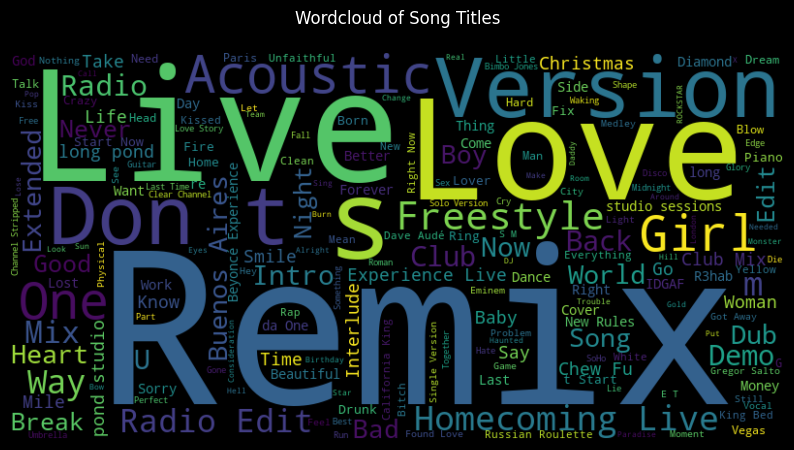

In [35]:
# Visualize words used in song titles using a wordcloud

# Get the song titles
song_titles = " ".join(df["Song Title"].values)

# Create a wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(
    song_titles
)

# Display the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Song Titles\n")
plt.show()

## Preprocessing the Data <a id='pre'></a>


In [36]:
# Create a new column for the processed lyrics
df["Processed Lyrics"] = df["Song Lyrics"]
df["Processed Lyrics"][0]

"thought i'd end up with sean but he wasn't a match wrote some songs about ricky now i listen and laugh even almost got married and for pete i'm so thankful wish i could say thank you to malcolm 'cause he was an angel  pre one taught me love one taught me patience and one taught me pain now i'm so amazing say i've loved and i've lost but that's not what i see so look what i got look what you taught me and for that i say   thank you next next thank you next next thank you next i'm so fuckin' grateful for my ex thank you next next thank you next next thank you next next i'm so fuckin'   spend more time with my friends i ain't worried 'bout nothin' plus i met someone else we havin' better discussions i know they say i move on too fast but this one gon' last 'cause her name is ari and i'm so good with that so good with that  pre she taught me love love she taught me patience patience how she handles pain pain that shit's amazing yeah she's amazing i've loved and i've lost yeah yeah but tha

In [37]:
# A function to divide the lyrics into sentences based on the double space
def divide_lyrics_into_sentences(lyrics):
    return lyrics.split("  ")

In [38]:
# Divide the lyrics into sentences based on sentence tokenization
df["Processed Lyrics"] = df["Processed Lyrics"].apply(divide_lyrics_into_sentences)

In [39]:
df["Processed Lyrics"][0]

["thought i'd end up with sean but he wasn't a match wrote some songs about ricky now i listen and laugh even almost got married and for pete i'm so thankful wish i could say thank you to malcolm 'cause he was an angel",
 "pre one taught me love one taught me patience and one taught me pain now i'm so amazing say i've loved and i've lost but that's not what i see so look what i got look what you taught me and for that i say",
 " thank you next next thank you next next thank you next i'm so fuckin' grateful for my ex thank you next next thank you next next thank you next next i'm so fuckin'",
 " spend more time with my friends i ain't worried 'bout nothin' plus i met someone else we havin' better discussions i know they say i move on too fast but this one gon' last 'cause her name is ari and i'm so good with that so good with that",
 "pre she taught me love love she taught me patience patience how she handles pain pain that shit's amazing yeah she's amazing i've loved and i've lost yeah

In [40]:
# Divide the list of sentences into a multiple rows
df = df.explode("Processed Lyrics")

In [41]:
# Show the number of rows in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29932 entries, 0 to 3244
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Artist Name       29932 non-null  object
 1   Song Title        29932 non-null  object
 2   Song Lyrics       29932 non-null  object
 3   Release Year      29932 non-null  int32 
 4   Processed Lyrics  29932 non-null  object
dtypes: int32(1), object(4)
memory usage: 1.3+ MB


In [42]:
# show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year,Processed Lyrics
1277,Ed Sheeran,I’m a Mess,oh i'm a mess right now inside out searching f...,2014,see the flames inside my eyes it burns so bri...
1250,Ed Sheeran,Thinking Out Loud,when your legs don't work like they used to be...,2014,people fall in love in mysterious ways maybe j...
2853,Rihanna,Photographs (Chew Fu 35mm Fix),rihanna all i've got all i've got all i've got...,2010,drop chew fu
58,Ariana Grande,Sometimes,la la la la la la la la la la la la la la la l...,2016,it used to be easy for someone to steal me now...
799,Drake,Emotionless,mariah carey you've got me feeling emotions ay...,2018,mariah carey you've got me fe you ohhhh you'v...


In [43]:
# Convert the lyrics to lowercase
df["Processed Lyrics"] = df["Processed Lyrics"].apply(lambda x: x.lower())

In [44]:
# Display the lyrics of the first song in the dataset
df["Processed Lyrics"][0]

0    thought i'd end up with sean but he wasn't a m...
0    pre one taught me love one taught me patience ...
0     thank you next next thank you next next thank...
0     spend more time with my friends i ain't worri...
0    pre she taught me love love she taught me pati...
0     thank you next thank you next thank you next ...
0    post thank you next thank you next thank you n...
0     one day i'll walk down the aisle holding hand...
0    pre i've got so much love love got so much pat...
0     thank you next thank you next thank you next ...
0    post thank you next thank you next thank you n...
Name: Processed Lyrics, dtype: object

In [45]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year,Processed Lyrics
733,Coldplay,Midnight (Henrik Schwarz Remix),in the darkness before the dawn in the darknes...,2014,in the darkness before the dawn in the swirli...
2425,Nicki Minaj,Bed of Lies,skylar grey ohohoh yeah skylar grey do you e...,2014,nicki minaj i just figured if you saw me if y...
2827,Rihanna,Diamonds (The Bimbo Jones Vocal Edit),shine bright like a diamond shine bright like ...,2012,palms rise to the universe as we moonshine an...
1198,Dua Lipa,Break My Heart (Joris Voorn Remix),pre centre of attention you know you can get w...,2020,pre centre of attention you know you can get w...
3210,Taylor Swift,Wildest Dreams (R3hab Remix),he said let's get out of this town drive out o...,2015,he's so tall and handsome as hell he's so bad ...


In [46]:
# Remove punctuation from the lyrics
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"

df["Processed Lyrics"] = df["Processed Lyrics"].apply(
    lambda x: "".join([l for l in x if l not in punctuation])
)

In [47]:
# Remove any special characters from the lyrics
df["Processed Lyrics"] = df["Processed Lyrics"].str.replace(r"[^a-zA-Z0-9 ]", "")

In [48]:
# Display the lyrics of the first song in the dataset
df["Processed Lyrics"][0]

0    thought id end up with sean but he wasnt a mat...
0    pre one taught me love one taught me patience ...
0     thank you next next thank you next next thank...
0     spend more time with my friends i aint worrie...
0    pre she taught me love love she taught me pati...
0     thank you next thank you next thank you next ...
0    post thank you next thank you next thank you n...
0     one day ill walk down the aisle holding hands...
0    pre ive got so much love love got so much pati...
0     thank you next thank you next thank you next ...
0    post thank you next thank you next thank you n...
Name: Processed Lyrics, dtype: object

In [49]:
# Remove stopwords from the lyrics
stop_words = set(stopwords.words("english"))

df["Processed Lyrics"] = df["Processed Lyrics"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

In [50]:
# Display the lyrics of the first song in the dataset
df["Processed Lyrics"][0]

0    thought id end sean wasnt match wrote songs ri...
0    pre one taught love one taught patience one ta...
0    thank next next thank next next thank next im ...
0    spend time friends aint worried bout nothin pl...
0    pre taught love love taught patience patience ...
0    thank next thank next thank next thank next th...
0      post thank next thank next thank next im fuckin
0    one day ill walk aisle holding hands mama ill ...
0    pre ive got much love love got much patience p...
0    thank next thank next thank next thank next th...
0    post thank next thank next thank next yeah yee...
Name: Processed Lyrics, dtype: object

In [51]:
# Remove any extra spaces from the lyrics
df["Processed Lyrics"] = df["Processed Lyrics"].apply(lambda x: " ".join(x.split()))

In [52]:
# Set any processed lyrics value to null if the language isn't english
i = 0


def detect_language(text):
    global i
    print("Processing row: ", i, end="\r")
    i += 1

    try:
        if detect(text) == "en":
            return text
        else:
            return None
    except:
        return None

In [53]:
# Apply the detect_language function to the processed lyrics column
df["Processed Lyrics"] = df["Processed Lyrics"].apply(detect_language)

In [54]:
# Remove any rows where the processed lyrics is null
df = df.dropna(subset=["Processed Lyrics"])
df.reset_index(drop=True, inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22319 entries, 0 to 22318
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Artist Name       22319 non-null  object
 1   Song Title        22319 non-null  object
 2   Song Lyrics       22319 non-null  object
 3   Release Year      22319 non-null  int32 
 4   Processed Lyrics  22319 non-null  object
dtypes: int32(1), object(4)
memory usage: 784.8+ KB


In [56]:
# Perform text lemmatization on the lyrics
lemmatizer = WordNetLemmatizer()

df["Processed Lyrics"] = df["Processed Lyrics"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

In [57]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year,Processed Lyrics
4076,Coldplay,Hurts Like Heaven,duction written in graffiti on a in a park ...,2011,hook cause use heart weapon hurt like heaven
9252,Ed Sheeran,Sing (Live @ 1Live Radiokonzert),it's late in the evening glass on the side i'v...,2014,late evening glass side ive sat night ignoring...
14998,Lady Gaga,The Edge of Glory,there ain't no reason you and me should be alo...,2011,another shot kiss side tonight yeah baby tonig...
7698,Dua Lipa,Hotter Than Hell (Jack Wins Remix),hotter than hell hotter than hell he calls m...,2016,go right make feel right lay right make right ...
22070,Taylor Swift,Love Story (Live From Clear Channel Stripped 2...,we were both young when i first saw you i clos...,2008,cause romeo scarlet letter daddy said stay awa...


In [58]:
# Perform text stemming on the lyrics
stemmer = SnowballStemmer("english")

df["Processed Lyrics"] = df["Processed Lyrics"].apply(
    lambda x: " ".join([stemmer.stem(word) for word in x.split()])
)

In [59]:
# Show the number of words in the lyrics of the first song in the dataset
print(
    "Number of words in the processed lyrics of the first song: ",
    len(df["Processed Lyrics"][0].split()),
)

print(
    "Original number of words in the lyrics of the first song: ",
    len(df["Song Lyrics"][0].split()),
)

Number of words in the processed lyrics of the first song:  25
Original number of words in the lyrics of the first song:  463


In [60]:
# Map the artist names to integers
artist_names = df["Artist Name"].unique()
artist_names_map = {artist: i for i, artist in enumerate(artist_names)}
df["Artist Name Map"] = df["Artist Name"].map(artist_names_map)

In [61]:
# Show the number of artists in the dataset
number_of_artists = len(artist_names)
number_of_artists

13

In [62]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year,Processed Lyrics,Artist Name Map
20297,Taylor Swift,Last Kiss,i still remember the look on your face lit thr...,2010,ill go sit floor wear cloth know dont know som...,12
20437,Taylor Swift,I Almost Do,i bet this time of night youre still up i bet ...,2012,bet time night your still bet your tire long h...,12
10953,Eminem,Drop the Bomb on ’Em,yeah boy dem better ring the alarm boy dem kno...,2009,yeah boy dem better ring alarm boy dem know wh...,6
13510,Katy Perry,Bigger Than Me,i can see it happening happen i can see it hap...,2017,someth bigger feel begin someth bigger yeah fe...,8
14066,Katy Perry,Spit,if you came by me would i crown you my king or...,2001,time time id live life sin knew hurt bad wasnt...,8


In [63]:
df["Processed Lyrics"][0]

'thought id end sean wasnt match wrote song ricki listen laugh even almost got marri pete im thank wish could say thank malcolm caus angel'

## Feature Extraction <a id='feat'></a>

In [64]:
# Split the dataset into target and features
X = df["Processed Lyrics"]
y = df["Artist Name Map"]

In [65]:
MAX_NUM_WORDS = 15000  # Maximum number of words to be used in the tokenizer
EMBEDDING_DIM = 200  # Dimension of the word embeddings
TEST_AND_VALIDATION_SPLIT = (
    0.2  # Percentage of the data to be used for testing and validation
)
max_sequence_length = max([len(x.split()) for x in X]) + 1  # Maximum sequence length
max_sequence_length

659

In [66]:
# One hot encode the target variable
y = to_categorical(np.asarray(y))

In [67]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_AND_VALIDATION_SPLIT, random_state=420
)

In [68]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (17855,)
Shape of X_test:  (4464,)
Shape of y_train:  (17855, 13)
Shape of y_test:  (4464, 13)


In [69]:
# Tokenize the text data
tokenizer = Tokenizer(
    num_words=MAX_NUM_WORDS
)  # Setting the maximum number of words to be used in the tokenizer
tokenizer.fit_on_texts(X_train)  # Fitting the tokenizer on the training data
train_sequences = tokenizer.texts_to_sequences(
    X_train
)  # Converting the training data to sequences
test_sequences = tokenizer.texts_to_sequences(
    X_test
)  # Converting the testing data to sequences

word_index = tokenizer.word_index  # Getting the word index
print("Number of unique words: ", len(word_index))

Number of unique words:  18224


In [111]:
# Save the tokenizer
with open("./models/tokenizer.pkl", "wb") as f:
    dill.dump(tokenizer, f)

In [70]:
print(X_train[0])
print(train_sequences[0])

thought id end sean wasnt match wrote song ricki listen laugh even almost got marri pete im thank wish could say thank malcolm caus angel
[27, 117, 266, 15, 46, 66, 50, 15, 27, 117, 266, 15, 46, 66, 50]


In [71]:
# Pad the sequences
X_train = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [72]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_AND_VALIDATION_SPLIT, random_state=420
)

In [73]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (14284, 659)
Shape of X_val:  (3571, 659)
Shape of X_test:  (4464, 659)
Shape of y_train:  (14284, 13)
Shape of y_val:  (3571, 13)
Shape of y_test:  (4464, 13)


In [74]:
# Setting the glove directory path
GLOVE_PATH = "C:\Datasets\glove.6B"

In [75]:
# Load the GloVe word embeddings into a dictionary

embeddings_index = {}  # Initialize the embeddings index dictionary

# Open the GloVe word embeddings file
with open(os.path.join(GLOVE_PATH, "glove.6B.200d.txt"), encoding="utf8") as f:

    # Loop through each line in the file
    for line in f:
        values = line.split()  # Split the line by spaces
        word = values[0]  # Get the word
        coefs = np.asarray(values[1:], dtype="float32")  # Get the coefficients
        embeddings_index[word] = (
            coefs  # Add the word and its coefficients to the dictionary
        )

In [76]:
print("Found %s word vectors in Glove embeddings." % len(embeddings_index))
print("Embedding for the word 'love':")
print(embeddings_index["love"])

Found 400000 word vectors in Glove embeddings.
Embedding for the word 'love':
[ 3.0443e-01  1.3912e-01 -2.2321e-01  5.5030e-02 -3.9927e-01 -9.1646e-02
 -6.0113e-01  3.1169e-02 -2.0895e-01  5.8123e-01 -3.3094e-01  5.7695e-01
 -3.1589e-01  9.8061e-02 -2.8631e-01  1.2140e-01 -8.4150e-02  7.6244e-01
  5.2208e-01  4.3290e-01  6.8615e-01  1.6706e+00  3.7482e-01 -1.8729e-01
  6.7264e-01 -2.6011e-01  4.2251e-01  2.3638e-01 -2.7498e-01  8.8301e-02
 -3.6438e-01  1.3059e-01  2.6137e-01 -3.4149e-02 -1.8843e-01 -5.1515e-01
 -4.7131e-01 -3.1717e-02  8.1075e-02 -3.1137e-01 -3.7055e-01  1.7943e-01
  8.8090e-04  6.2601e-02 -2.7884e-01  8.3498e-02  6.4031e-01 -3.7709e-01
  4.2937e-01  5.1991e-01 -9.2588e-02 -2.0270e-01 -6.1070e-02  8.0062e-01
  2.1493e-01 -2.0545e-01 -2.0012e-01  1.9416e-01  5.5192e-01 -1.7063e-01
 -3.1811e-01 -2.7010e-01 -5.6274e-01  7.4019e-01 -3.6589e-01 -3.0555e-01
  1.7031e-01  6.5522e-01  4.0899e-01  2.2429e-01  6.3616e-01 -5.9560e-01
  3.8884e-03 -5.1774e-02 -6.4669e-01 -2.8715e-

In [77]:
# Creating the embedding matrix
number_of_words = min(MAX_NUM_WORDS, len(word_index) + 1)  # Number of words
embedding_matrix = np.zeros(
    (number_of_words, EMBEDDING_DIM)
)  # Initialize the embedding matrix
print("The shape of the embedding matrix", embedding_matrix.shape)

The shape of the embedding matrix (15000, 200)


In [78]:
# Fill the embedding matrix with the GloVe embeddings
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [79]:
# Initialize the embedding layer with the GloVe embeddings
embedding_layer = Embedding(
    number_of_words,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_sequence_length,
    trainable=False,
)

In [80]:
# A function that preprocesses the lyrics of the user input
def preprocess_lyrics(lyrics, model_name):
    lyrics = lyrics.lower()
    lyrics = "".join([l for l in lyrics if l not in punctuation])
    lyrics = lyrics.replace(r"[^a-zA-Z0-9 ]", "")
    lyrics = " ".join([word for word in lyrics.split() if word not in stop_words])
    lyrics = " ".join(lemmatizer.lemmatize(word) for word in lyrics.split())
    lyrics = " ".join(stemmer.stem(word) for word in lyrics.split())

    lyrics = [lyrics]
    lyrics = tokenizer.texts_to_sequences(lyrics)
    lyrics = pad_sequences(lyrics, maxlen=max_sequence_length)


    return lyrics

## CNN Model <a id='cnn'></a>

In [81]:
# Create the first CNN model with the embedding layer initialized with GloVe embeddings
cnn_model_1 = Sequential()
cnn_model_1.add(embedding_layer)
cnn_model_1.add(Conv1D(64, 5, activation="relu"))
cnn_model_1.add(MaxPooling1D(5))
cnn_model_1.add(GlobalMaxPooling1D())
cnn_model_1.add(Dense(number_of_artists, activation="softmax"))

In [82]:
# Show the model summary
cnn_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [83]:
# Compile the model
cnn_model_1.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [84]:
# Fit the model
start_time = time.time()
history = cnn_model_1.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
)
end_time = time.time()
print("Time taken to train the model: ", end_time - start_time)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.3057 - loss: 2.1953 - val_accuracy: 0.5357 - val_loss: 1.5770
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6097 - loss: 1.3683 - val_accuracy: 0.5979 - val_loss: 1.3847
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7220 - loss: 1.0156 - val_accuracy: 0.6239 - val_loss: 1.2841
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7955 - loss: 0.7860 - val_accuracy: 0.6567 - val_loss: 1.2033
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8480 - loss: 0.6213 - val_accuracy: 0.6796 - val_loss: 1.1594
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8932 - loss: 0.4745 - val_accuracy: 0.6866 - val_loss: 1.1544
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9228 - loss: 0.3691 - val_accuracy: 0.6928 - val_loss: 1.1699
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9430 - loss: 0.3014 - val_

In [85]:
# Evaluate the model
loss, accuracy = cnn_model_1.evaluate(X_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6919 - loss: 1.2941
Test Loss:  1.2980300188064575
Test Accuracy:  0.6899641752243042


In [86]:
# Test the model on a random song lyric
song_lyric = ""

while song_lyric == "":
    song_lyric = input("Enter a song lyric: ")
    if song_lyric.__len__() > max_sequence_length:
        print("The entered song lyric is too long. Please enter a shorter song lyric.")
        song_lyric = ""
        continue

print("The entered song lyric is: ", song_lyric)

The entered song lyric is:  Work, work, work, work, work, work He said me haffi


In [87]:
# Preprocess the song lyric
processed_lyric = preprocess_lyrics(song_lyric, "DL")

In [88]:
# Predict the artist of the song lyric
prediction = cnn_model_1.predict(processed_lyric)
print("The predicted artist is: ", artist_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
The predicted artist is:  Taylor Swift


In [89]:
# Save the model
cnn_model_1.save(
    "./models/Song Lyrics Classification CNN Model with GloVe Embeddings.h5"
)

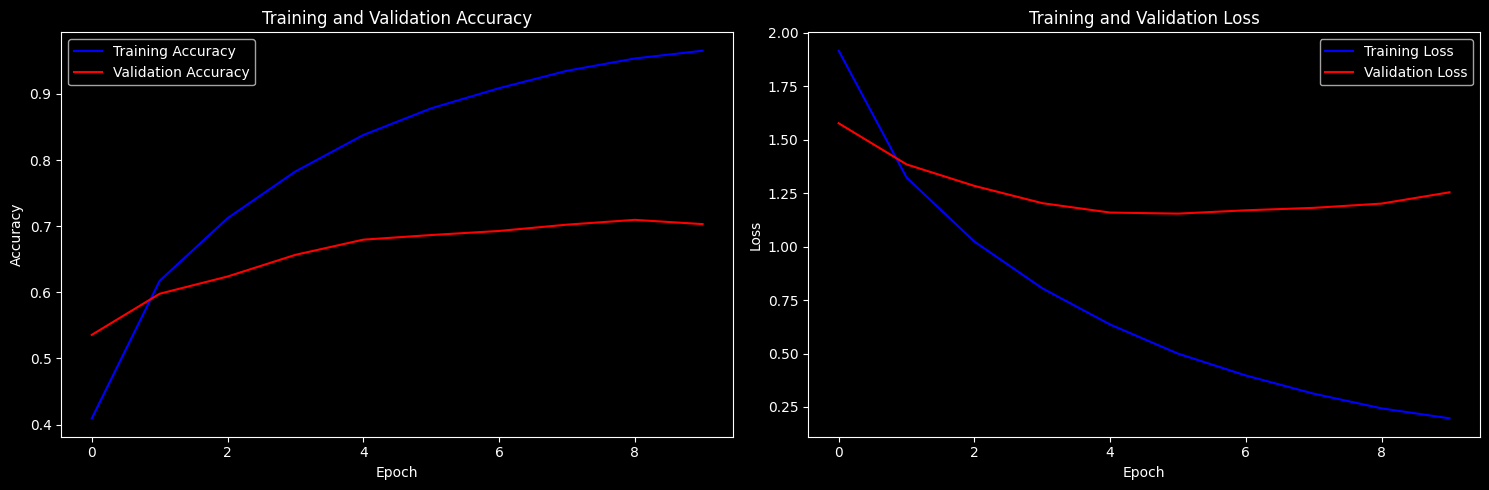

In [90]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 5))

# Plot the training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color="b")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="r")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color="b")
plt.plot(history.history["val_loss"], label="Validation Loss", color="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

CNN Model with GloVe Embeddings Results:
-  Training Accuracy: 0.97
-  Validation Accuracy: 0.70
-  Test Accuracy: 0.68

The model did not generalize well on the validation set, which indicates could indicate overfitting. The model was trained on a small dataset which could be the reason for the overfitting, or the model architecture may not be suitable for the dataset.

Possible solutions to improve the model:
-  Use LSTM model instead of CNN which is more suitable for text data
-  Use a trainable embedding layer instead of GloVe embeddings which may not be suitable especially for a dataset containing lyrics
-  Increase the size of the dataset
-  Use a pre-trained model like BERT or GPT-3

In [91]:
# Create the second CNN model with a learnable embedding layer
cnn_model_2 = Sequential()
cnn_model_2.add(Embedding(MAX_NUM_WORDS, 128, input_length=max_sequence_length))
cnn_model_2.add(Conv1D(64, 5, activation="relu"))
cnn_model_2.add(MaxPooling1D(5))
cnn_model_2.add(GlobalMaxPooling1D())
cnn_model_2.add(Dense(number_of_artists, activation="softmax"))

In [92]:
# Show the model summary
cnn_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Compile the model
cnn_model_2.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [94]:
# Fit the model
start_time = time.time()
history = cnn_model_2.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
)
end_time = time.time()
print("Time taken to train the model: ", end_time - start_time)

Epoch 1/10


447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.2660 - loss: 2.2856 - val_accuracy: 0.5875 - val_loss: 1.4630
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7043 - loss: 1.1185 - val_accuracy: 0.7219 - val_loss: 0.9930
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.8910 - loss: 0.4845 - val_accuracy: 0.7533 - val_loss: 0.8731
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9600 - loss: 0.2163 - val_accuracy: 0.7665 - val_loss: 0.8583
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9808 - loss: 0.1114 - val_accuracy: 0.7698 - val_loss: 0.8814
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9906 - loss: 0.0611 - val_accuracy: 0.7763 - val_loss: 0.9085
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9933 - loss: 0.0436 - val_accuracy: 0.7746 - val_loss: 0.9417
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9960 - loss: 0.0255 - val_accurac

In [95]:
# Evaluate the model
loss, accuracy = cnn_model_2.evaluate(X_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7703 - loss: 1.0241
Test Loss:  1.0555593967437744
Test Accuracy:  0.7685931921005249


In [96]:
# Test the model on a random song lyric
song_lyric = ""

while song_lyric == "":
    song_lyric = input("Enter a song lyric: ")
    if song_lyric.__len__() > max_sequence_length:
        print("The entered song lyric is too long. Please enter a shorter song lyric.")
        song_lyric = ""
        continue

print("The entered song lyric is: ", song_lyric)

The entered song lyric is:  Work, work, work, work, work, work He said me haffi


In [97]:
# Preprocess the song lyric
processed_lyric = preprocess_lyrics(song_lyric, "DL")

In [98]:
# Predict the artist of the song lyric
prediction = cnn_model_2.predict(processed_lyric)
print("The predicted artist is: ", artist_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
The predicted artist is:  Taylor Swift


In [99]:
# Save the model
cnn_model_2.save(
    "./models/Song Lyrics Classification CNN Model with Learnable Embeddings.h5"
)

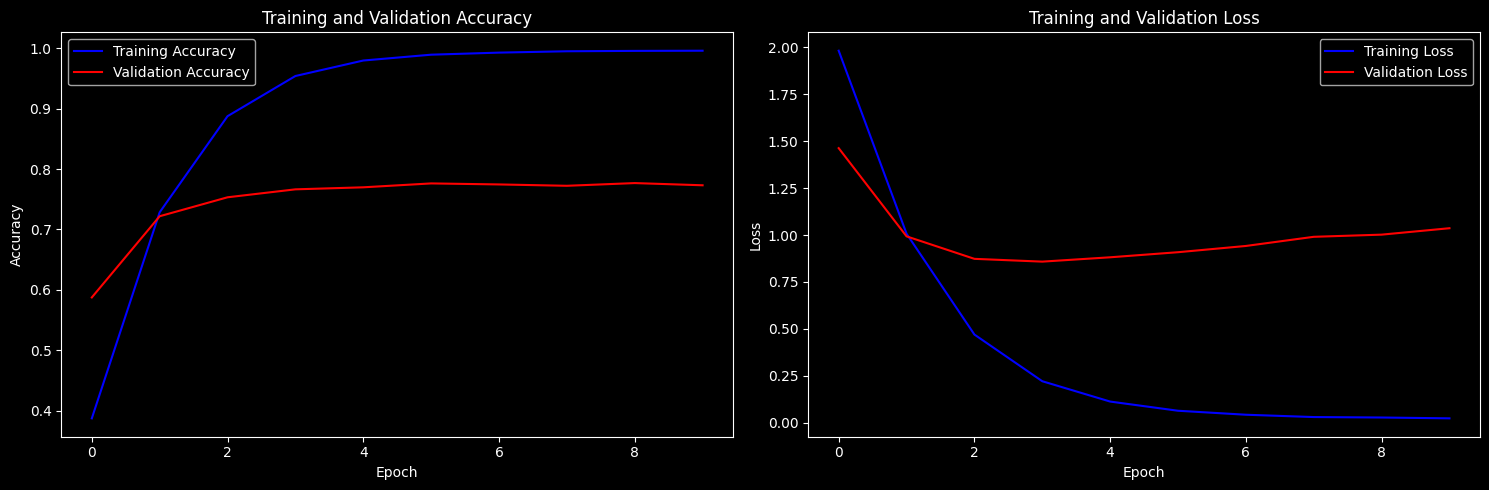

In [100]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 5))

# Plot the training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color="b")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="r")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color="b")
plt.plot(history.history["val_loss"], label="Validation Loss", color="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

CNN Model with Trainable Embeddings Results:
-  Training Accuracy: 0.99
-  Validation Accuracy: 0.77
-  Test Accuracy: 0.76

The model with trainable embeddings performed better than the model with GloVe embeddings. The model was able to generalize well on the validation set and the test set showing that the model was not overfitting. The model was able to learn the embeddings that are more suitable for the dataset.

Next, I will try to implement an LSTM model to see if it performs better than the CNN model.

## LSTM Model <a id='lstm'></a>

In [101]:
# Create the first LSTM model with a learnable embedding layer
lstm_model_1 = Sequential()
lstm_model_1.add(Embedding(MAX_NUM_WORDS, 128, input_length=max_sequence_length))
lstm_model_1.add(LSTM(32))
lstm_model_1.add(Dense(number_of_artists, activation="softmax"))

In [102]:
# Show the model summary
lstm_model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Compile the model
lstm_model_1.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [104]:
# Fit the model
start_time = time.time()
history = lstm_model_1.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
)
end_time = time.time()
print("Time taken to train the model: ", end_time - start_time)

Epoch 1/10


447/447 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - accuracy: 0.2127 - loss: 2.3527 - val_accuracy: 0.4917 - val_loss: 1.6680
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accuracy: 0.6090 - loss: 1.3517 - val_accuracy: 0.6172 - val_loss: 1.2984
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 64s 144ms/step - accuracy: 0.7600 - loss: 0.8657 - val_accuracy: 0.6634 - val_loss: 1.1827
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 75s 167ms/step - accuracy: 0.8390 - loss: 0.5969 - val_accuracy: 0.7001 - val_loss: 1.1505
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 78s 175ms/step - accuracy: 0.8822 - loss: 0.4361 - val_accuracy: 0.7130 - val_loss: 1.1449
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 77s 173ms/step - accuracy: 0.9006 - loss: 0.3737 - val_accuracy: 0.7090 - val_loss: 1.1762
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 76s 170ms/step - accuracy: 0.9193 - loss: 0.2974 - val_accuracy: 0.7110 - val_loss: 1.2149
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 76s 169ms/step - accuracy: 0.9397 - loss: 0.2366 - val

In [105]:
# Evaluate the model
loss, accuracy = lstm_model_1.evaluate(X_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7270 - loss: 1.2617
Test Loss:  1.271226167678833
Test Accuracy:  0.7275985479354858


In [106]:
# Test the model on a random song lyric
song_lyric = ""

while song_lyric == "":
    song_lyric = input("Enter a song lyric: ")
    if song_lyric.__len__() > max_sequence_length:
        print("The entered song lyric is too long. Please enter a shorter song lyric.")
        song_lyric = ""
        continue

print("The entered song lyric is: ", song_lyric)

The entered song lyric is:  Work, work, work, work, work, work He said me haffi


In [107]:
# Preprocess the song lyric
processed_lyric = preprocess_lyrics(song_lyric, "DL")

In [108]:
# Predict the artist of the song lyric
prediction = lstm_model_1.predict(processed_lyric)
print("The predicted artist is: ", artist_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
The predicted artist is:  Beyoncé


In [109]:
# Save the model
lstm_model_1.save(
    "./models/Song Lyrics Classification LSTM Model with Learnable Embeddings.h5"
)

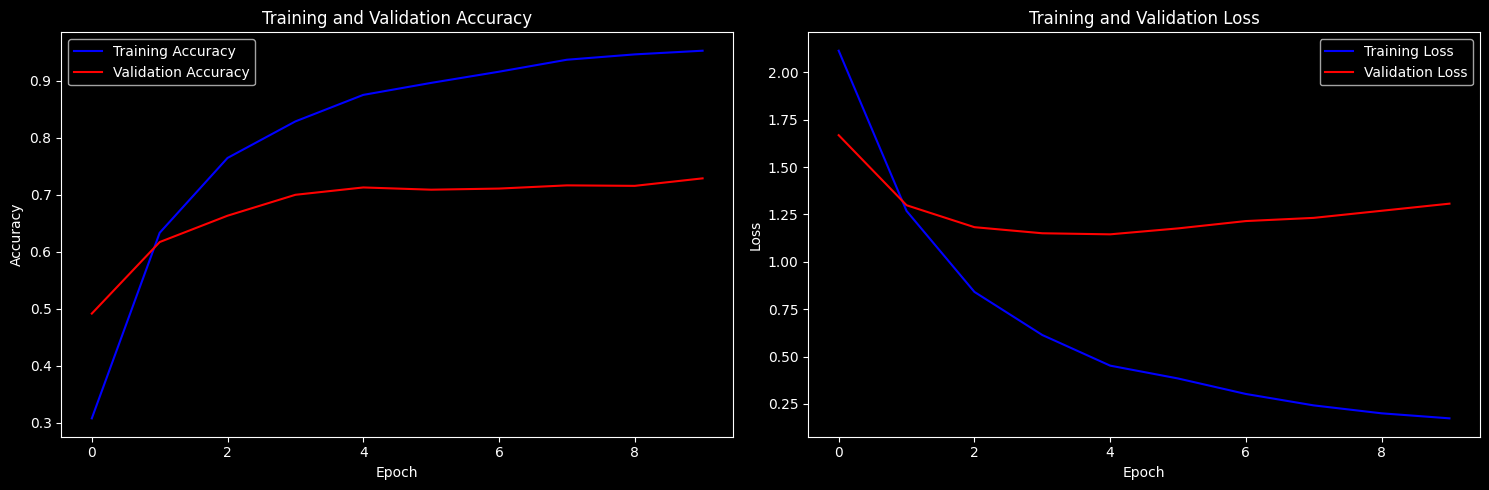

In [110]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 5))

# Plot the training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color="b")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="r")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color="b")
plt.plot(history.history["val_loss"], label="Validation Loss", color="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

LSMT Model with trainable embeddings Results:
-  Training Accuracy: 0.95
-  Validation Accuracy: 0.72
-  Test Accuracy: 0.72

The LSTM model performed better than the CNN model with GloVe embeddings but worse than the CNN model with trainable embeddings. The model was able to generalize well on the validation set and the test set showing that the model was not overfitting. The model was able to learn the embeddings that are more suitable for the dataset.